In [1]:
import os
import math
import nltk
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def evaluate(test_sentences, tagged_test_sentences):
    gold = [str(tag) for sentence in test_sentences for token, tag in sentence]
    pred = [str(tag) for sentence in tagged_test_sentences for token, tag in sentence]
    print(metrics.classification_report(gold, pred))
    
def get_token_tag_tuples(sent):
    return([nltk.tag.str2tuple(t) for t in sent.split()])

def get_tagged_sentences(text):
    sentences = []
    
    blocks = text.split("======================================")
    for block in blocks:
        sents = block.split("\n\n")
        for sent in sents:
            sent = sent.replace("\n", "").replace("[", "").replace("]", "")
            if sent != "":
                sentences.append(sent)
    return sentences

def load_treebank_splits(datadir):
    
    train = []
    dev = []
    test = []
    
    print("Loading treebank data...")
    
    for subdir, dirs, files in os.walk(datadir):
        for filename in files:
            if filename.endswith(".pos"):
                filepath = subdir + os.sep + filename
                with open(filepath, "r") as fh:
                    text = fh.read()
                    if int(subdir.split(os.sep)[-1]) in range(0, 19):
                        train += get_tagged_sentences(text)
                        
                    if int(subdir.split(os.sep)[-1]) in range(19, 22):
                        dev += get_tagged_sentences(text)
                        
                    if int(subdir.split(os.sep)[-1]) in range(22, 25):
                        test += get_tagged_sentences(text)
                        
    print("Train set size: ", len(train))
    print("Dev set size: ", len(dev))
    print("Test set size: ", len(test))
    
    return train, dev, test


In [3]:
def main():
    
    # Set path for datadir
    datadir = os.path.join("data", "penn-treebank3-wsj", "wsj")
    
    train, dev, test = load_treebank_splits(datadir)
    
    ## For evaluation against the default NLTK POS tagger
    
    test_sentences = [get_token_tag_tuples(sent) for sent in test]
    tagged_test_sentences = [nltk.pos_tag([token for token, tag in sentence]) for sentence in test_sentences]
    evaluate(test_sentences, tagged_test_sentences)
    

In [4]:
#if __name__ == "__main__":
#    main()

In [5]:
def get_words(tagged_words, vocab):
    tokens = []
    for word,tag in tagged_words:
        if word not in vocab:
            tokens.append('<unk>')
        else :
            tokens.append(word)
            
    return tokens

In [6]:
# Set path for datadir
datadir = os.path.join("data", "penn-treebank3-wsj", "wsj")
    
train, dev, test = load_treebank_splits(datadir)
    
## For evaluation against the default NLTK POS tagger
    
test_sentences = [get_token_tag_tuples(sent) for sent in test]
tagged_test_sentences = [nltk.pos_tag([token for token, tag in sentence]) for sentence in test_sentences]
evaluate(test_sentences, tagged_test_sentences)

Loading treebank data...
Train set size:  51681
Dev set size:  7863
Test set size:  9046


/Users/himanshu/Indx/IIT/env38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/himanshu/Indx/IIT/env38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           #       1.00      1.00      1.00        22
           $       1.00      1.00      1.00      1138
          ''       1.00      1.00      1.00      1423
           (       1.00      1.00      1.00       249
           )       1.00      1.00      1.00       252
           ,       1.00      1.00      1.00      9056
           .       1.00      1.00      1.00      7035
           :       1.00      1.00      1.00       983
          CC       1.00      1.00      1.00      4289
          CD       0.99      0.99      0.99      6023
          DT       0.97      0.99      0.98     14946
          EX       0.97      0.97      0.97       174
          FW       0.47      0.18      0.26        38
          IN       0.98      0.97      0.98     18147
          JJ       0.89      0.91      0.90     10704
         JJR       0.81      0.88      0.85       581
     JJR|RBR       0.00      0.00      0.00         4
         JJS       0.91    

/Users/himanshu/Indx/IIT/env38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
bos_tuple = ('(START)', '<START>')
eos_tuple = ('(STOP)', '<STOP>')
train_sentences = [get_token_tag_tuples(sent) for sent in train]
for i, sent in enumerate(train_sentences):
    train_sentences[i].insert(0,bos_tuple)
    train_sentences[i].append(eos_tuple)


In [8]:
# Getting list of tagged words in dataset
train_tagged_words = [tup for sent in train_sentences for tup in sent]
#print(len(train_tagged_words))
#train_tagged_words[:40]

In [9]:
# vocabulary
#voc_l = sorted({word for word,tag in train_tagged_words})
#voc_l.append('<unk>')
#voc_l.sort()

# limit the vocabulary to improve the performance and speed - reduces matrix size
# read the vocabulary data, split by each line of text, and save the list
with open("hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

# vocab: dictionary that has the index of the corresponding words
vocab = {} 

# Get the index of the corresponding words. 
for i, word in enumerate(sorted(voc_l)): 
    vocab[word] = i       

print(len(vocab))
#print([*vocab, ][:10])

23789


In [10]:
# number of tags
tags = sorted({tag for word,tag in train_tagged_words})
#print(len(tags))
#print(tags)

In [11]:
dev_sentences = [get_token_tag_tuples(sent) for sent in dev]
for i, sent in enumerate(dev_sentences):
    dev_sentences[i].insert(0,bos_tuple)
    dev_sentences[i].append(eos_tuple)

dev_tagged_words = [tup for sent in dev_sentences for tup in sent]
dev_words = get_words(dev_tagged_words, vocab) 
dev_gold = [str(tag) for token, tag in dev_tagged_words]
#print(len(dev_words))

In [12]:
test_sentences = [get_token_tag_tuples(sent) for sent in test]
for i, sent in enumerate(test_sentences):
    test_sentences[i].insert(0,bos_tuple)
    test_sentences[i].append(eos_tuple)

test_tagged_words = [tup for sent in test_sentences for tup in sent]
test_words = get_words(test_tagged_words, vocab) 
test_gold = [str(tag) for token, tag in test_tagged_words]

## Hidden Markov Model

In [13]:
# Read the training data, and construct the transition and emission tables.
# implement a fully observed HMM by estimating parameters from a training set using 
# maximum a posteriori (MAP) estimation.
# Implement a bigram HMM with add-α smoothing. 
# Remember to include ⟨START⟩ and ⟨STOP⟩ tokens at the beginning and ending of each sentence.

In [14]:
def create_dictionaries(sentences, vocab):
    """
    Input: 
        sentences: list of word,tag tuples.
        vocab: vocabulary (list of words)
    Output:
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
            It contains the number of times the 'word' came with 'tag'.
            We will use these counts to calculate the emission probability of a 'word' for a given 'tag'
        transition_counts: a dictionary where the keys are (prev_tag, tag) and the values are the counts
            It contain the number of times a sequence of two tags (prev_tag, tag) has occurred in that order.
            We will use that count to later calculate the probability of transitioning from said prev_tag to tag.
        tag_counts: a dictionary where the keys are the tags and the values are the counts 
            (the number of times each tag occurred)
    """
    
    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    prev_tag = ''
    
    # use 'i' to track the line number in the corpus
    i = 0 
    
    for w,tag in sentences:
        # Increment the word_tag count
        i += 1
        
        # Every 50,000 words, print the word count
        if i % 50000 == 0:
            print(f"word count = {i}")
            
        #print(word,tag)
        if w not in vocab:
            word = '<unk>'
        else:
            word = w
            
        # Increment the transition count for the previous word and tag
        if prev_tag != '':
            transition_counts[(prev_tag, tag)] += 1
        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1
        # Increment the tag count
        tag_counts[(tag)] += 1
        # Set the previous tag to this tag (for the next iteration of the loop)
        prev_tag = tag
    
    return emission_counts, transition_counts, tag_counts

In [15]:
def createTransitionMatrix(alpha, tag_counts, transition_counts):
    ''' 
    Input: 
        alpha: number used for smoothing
        tag_counts: a dictionary mapping each tag to its respective count
        transition_counts: transition count for the previous word and tag
    Output:
        A: matrix of dimension (num_tags,num_tags)
    '''
    
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
    
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j])

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionaory
            if key in trans_keys: #complete this line
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts.get(key)
                
            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts.get(all_tags[i])
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and number of total tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha * num_tags)

    return A

In [16]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    '''
    Input: 
        alpha: tuning parameter used in smoothing 
        tag_counts: a dictionary mapping each tag to its respective count
        emission_counts: a dictionary where the keys are (tag, word) and the values are the counts
        vocab: vocabulary list
    Output:
        B: a matrix of dimension (num_tags, len(vocab))
    '''
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
    
    # Go through each row (POS tags)
    for i in range(num_tags): 
        
        # Go through each column (words)
        for j in range(num_words): 

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0
                    
            # Define the (POS tag, word) tuple for this row and column
            key = (all_tags[i], vocab[j])

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emis_keys: 
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts.get(key)
                
            # Get the count of the POS tag
            count_tag = tag_counts.get(all_tags[i])
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag + alpha * num_words)

    return B

In [17]:
print("Total = ", len(train_tagged_words))
emission_counts, transition_counts, tag_counts = create_dictionaries(train_tagged_words, vocab)

Total =  1073238
word count = 50000
word count = 100000
word count = 150000
word count = 200000
word count = 250000
word count = 300000
word count = 350000
word count = 400000
word count = 450000
word count = 500000
word count = 550000
word count = 600000
word count = 650000
word count = 700000
word count = 750000
word count = 800000
word count = 850000
word count = 900000
word count = 950000
word count = 1000000
word count = 1050000


In [18]:
# get all the POS states
states = sorted(tag_counts.keys())
print(f"Number of POS tags (number of 'states'): {len(states)}")
print("View these POS tags (states)")
print(states)

Number of POS tags (number of 'states'): 79
View these POS tags (states)
['#', '$', "''", '(', ')', ',', '.', ':', '<START>', '<STOP>', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'IN|JJ', 'IN|RB', 'JJ', 'JJR', 'JJS', 'JJ|JJR', 'JJ|NN', 'JJ|NNP', 'JJ|RB', 'JJ|VBN', 'LS', 'MD', 'MD|VB', 'NN', 'NNP', 'NNPS', 'NNPS|NNS', 'NNS', 'NNS|NN', 'NNS|VBZ', 'NN|CD', 'NN|JJ', 'NN|NNS', 'NN|POS', 'NN|VBG', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBR|JJR', 'RBS', 'RBS|JJS', 'RB|DT', 'RB|IN', 'RB|JJ', 'RB|RP', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBD|VBP', 'VBG', 'VBG|JJ', 'VBG|NN', 'VBG|NN|JJ', 'VBN', 'VBN|JJ', 'VBN|VBD', 'VBP', 'VBP|VB', 'VBP|VBD', 'VBZ', 'VB|IN', 'VB|NN', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [19]:
print("transition examples: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission examples: ")
for ex in list(emission_counts.items())[5:10]:
    print (ex)
print()

print("ambiguous word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition examples: 
(('<START>', 'NNP'), 8259)
(('NNP', 'NNP'), 35554)
(('NNP', ','), 12970)

emission examples: 
(('JJ', 'French'), 104)
(('JJ', 'state-controlled'), 10)
(('JJ', 'chemical'), 10)
(('NN', 'manufacturer'), 39)
(('VBZ', 'is'), 7118)

ambiguous word example: 
('VBP', 'back') 4
('RP', 'back') 55
('JJ', 'back') 26
('NN', 'back') 26
('VB', 'back') 20
('RB', 'back') 318


### Baseline tagger

In [20]:
# Predict based on the most frequent POS tag for the given word, as observed in the training set
def baseline_predict_pos(prep, emission_counts, vocab, states):
    '''
    Input: 
        prep: A list with the 'word' component of the tuples.
        emission_counts: a dictionary where the keys are (tag,word) tuples and the value is the count
        vocab: a dictionary where keys are words in vocabulary and value is an index
        states: a sorted list of all possible tags for this assignment
    Output: 
        pred: Predicted tags for each word
    '''
    
    pred = []
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    for word in prep: 

        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:

                # define the key as the tuple containing the POS and word
                pos_word_tup_key = (pos, word)
                # check if the (pos, word) key exists in the emission_counts dictionary
                if pos_word_tup_key in emission_counts:
                    # get the emission count of the (pos,word) tuple 
                    count = emission_counts.get(pos_word_tup_key)
                    # keep track of the POS with the largest count
                    if count > count_final:
                        # update the final count (largest count)
                        count_final = count
                        # update the final POS
                        pos_final = pos
                    
        pred.append(pos_final)
            
    return pred

In [21]:
baseline_pred_dev = baseline_predict_pos(dev_words, emission_counts, vocab, states)

In [22]:
accuracy_baseline_dev = metrics.accuracy_score(dev_gold, baseline_pred_dev)
print(f"Accuracy for Baseline Tagger is {accuracy_baseline_dev:.4f}")

Accuracy for Baseline Tagger is 0.9228


In [23]:
baseline_pred_test = baseline_predict_pos(test_words, emission_counts, vocab, states)

In [24]:
accuracy_baseline_test = metrics.accuracy_score(test_gold, baseline_pred_test)
print(f"Accuracy for Baseline Tagger is {accuracy_baseline_test:.4f}")

Accuracy for Baseline Tagger is 0.9247


### Using Alpha = 1

In [25]:
# alpha = smoothing parameter.
# smoothing: By adding in the numerator and in the denominator, instead of 0, we’ll end up with a very small number.
#alpha = 0.001
alpha = 1
print("\n Now using alpha = 1")

# A is Transition Matrix where A(i,j) gives probability of moving from state i to state j
A = createTransitionMatrix(alpha, tag_counts, transition_counts)


 Now using alpha = 1


In [26]:
# convert the matrix to a df for better readability
A_df = pd.DataFrame(A, columns = list(tags), index=list(tags))
display(A_df)

,#,$,'',(,),",",.,:,<START>,<STOP>,...,VBP|VB,VBP|VBD,VBZ,VB|IN,VB|NN,WDT,WP,WP$,WRB,``
#,0.004651,0.004651,0.004651,0.004651,0.004651,0.009302,0.004651,0.004651,0.004651,0.004651,...,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651,0.004651
$,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,...,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134,0.000134
'',0.000137,0.000273,0.006152,0.008202,0.003964,0.000957,0.002324,0.012303,0.000137,0.229938,...,0.000137,0.000137,0.120574,0.000137,0.000137,0.009433,0.002187,0.000547,0.003554,0.004375
(,0.000661,0.166557,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661,0.000661,0.006609,...,0.000661,0.000661,0.001322,0.000661,0.000661,0.005948,0.004627,0.000661,0.003305,0.023794
),0.000653,0.001306,0.000653,0.001306,0.000653,0.160679,0.128021,0.079686,0.000653,0.087524,...,0.000653,0.000653,0.043762,0.000653,0.000653,0.005225,0.003919,0.000653,0.000653,0.001960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WDT,0.000221,0.000221,0.000221,0.000442,0.000221,0.005750,0.000221,0.000663,0.000221,0.092437,...,0.000221,0.000221,0.281291,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.001106
WP,0.000403,0.000403,0.000403,0.000805,0.001208,0.006844,0.001610,0.000403,0.000403,0.160628,...,0.000403,0.000403,0.216184,0.000403,0.000403,0.000403,0.000403,0.000403,0.000403,0.001610
WP$,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.082031,...,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906,0.003906
WRB,0.000446,0.000446,0.000446,0.000893,0.000446,0.012054,0.004464,0.000446,0.000446,0.001339,...,0.000446,0.000446,0.008036,0.000446,0.000446,0.000893,0.000446,0.000446,0.000893,0.002679


In [27]:
#print(f"A at row 0, col 0: {A[0,0]:.9f}")
#print(f"A at row 3, col 1: {A[3,1]:.4f}")

#print("View a subset of transition matrix A")
#A_sub = pd.DataFrame(A[15:20,15:20], index=states[15:20], columns = states[15:20] )
#print(A_sub)

In [28]:
# create emission probability matrix. 
# The matrix B is of dimension (num_tags, N), 
#          where num_tags is the number of possible parts-of-speech tags. and N is size of vocabulary
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

In [29]:
# convert the matrix to a df for better readability
B_df = pd.DataFrame(B, columns = list(vocab), index=list(tags))
display(B_df)

,,!,#,$,%,&,','','40s,'60s,...,zeroing,zeros,zinc,zip,zombie,zone,zones,zoning,{,}
#,0.000042,0.000042,0.005726,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
$,0.000032,0.000032,0.000032,0.230851,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032
'',0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.004255,0.228977,0.000032,0.000032,...,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032
(,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,...,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.008405,0.000040
),0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,...,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.000040,0.008518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WDT,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,...,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035,0.000035
WP,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,...,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038,0.000038
WP$,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
WRB,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,...,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039,0.000039


In [30]:
#cidx  = ['Richter','10','shake', 'feel', 'Bay']

# Get the integer ID for each word
#cols = [vocab.index(a) for a in cidx]

# Choose POS tags to show in a sample dataframe
#rvals =['<START>','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
#rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags

#B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
#B_sub = B_df.loc[rvals, cidx]
#print(B_sub)

In [31]:
# create the auxiliary matrices bestProbs and bestPaths and populate the first column of each matrix. 
# Both matrices will have the size of NUMBER_OF_TAGS rows by corpus.size columns.
def initialize(states, tag_counts, A, B, corpus, vocab):
    '''
    Input: 
        states: a list of all possible parts-of-speech
        tag_counts: a dictionary mapping each tag to its respective count
        A: Transition Matrix of dimension (num_tags, num_tags)
        B: Emission Matrix of dimension (num_tags, len(vocab))
        corpus: a sequence of words whose POS is to be identified in a list 
        vocab: vocabulary
    Output:
        best_probs: matrix of dimension (num_tags, len(corpus)) of floats
        best_paths: matrix of dimension (num_tags, len(corpus)) of integers
    '''
    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("<START>")
    
    # Go through each of the POS tags
    for i in range(num_tags): 
    
        # Handle the special case when the transition from start token to POS tag i is zero
        if A[i][0] == 0: 
            
            # Initialize best_probs at POS tag 'i', column 0, to negative infinity
            best_probs[i,0] = float('-inf')
        
        # For all other cases when transition from start token to POS tag i is non-zero:
        else:
            
            # Initialize best_probs at POS tag 'i', column 0
            best_probs[i,0] = math.log(A[s_idx, i]) + math.log(B[i, vocab[corpus[0]]])
                        
    return best_probs, best_paths

In [32]:
# Populate matrices bestProbs and bestPaths for each word for every possible tag
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):
    '''
    Input: 
        A, B: The transiton and emission matrices respectively
        test_corpus: a list containing a preprocessed corpus
        best_probs: an initilized matrix of dimension (num_tags, len(corpus))
        best_paths: an initilized matrix of dimension (num_tags, len(corpus))
        vocab: a vocabulary 
    Output: 
        best_probs: a completed matrix of dimension (num_tags, len(corpus))
        best_paths: a completed matrix of dimension (num_tags, len(corpus))
    '''
    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))
            

        # For each unique POS tag that the current word can be
        for j in range(num_tags): 
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): 
            
                # Calculate the probability = 
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k, i-1] + math.log(A[k,j]) + math.log(B[j,vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: 
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

In [33]:
# returns a list of predicted POS tags for each word
# we’ll use bestPaths to backtrace the path that yielded the highest probability 
# which we’ll get from the last column of bestPaths corresponding to the last word in the sentence.
def viterbi_backward(best_probs, best_paths, corpus, states):
    '''
    This function returns the best path.
    
    '''
    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    ## Step 1 ##
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): 

        # If the probability of POS tag at row k 
        # is better than the previosly best probability for the last word:
        if best_probs[k, m-1] > best_prob_for_last_word: 
            
            # Store the new best probability for the lsat word
            best_prob_for_last_word = best_probs[k, m-1]
    
            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' dictionary
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[z[m-1]]
    
    ## Step 2 ##
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(m-1, -1, -1): 
        
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = z[i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i, i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' dictionary, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[z[i-1]]
        
    return pred

In [34]:
# Using Viterbi, find the best sequence of tags matches given sentence
def predictPOSSequence(sentences, states, A, B, vocab):
    # initialize the best_paths and best_probabilities matrices
    best_probs, best_paths = initialize(states, tag_counts, A, B, sentences, vocab)
    
    # populating both matrices column by column, 
    # at each step finding the best probability and path for the current subsequence.
    best_probs, best_paths = viterbi_forward(A, B, sentences, best_probs, best_paths, vocab)
    
    # use bestPaths to backtrace the path that yielded the highest probability 
    # which we’ll get from the last column of bestPaths corresponding to the last word in the sentence.
    pred = viterbi_backward(best_probs, best_paths, sentences, states)
    
    return pred


In [35]:
print("\nPredicting using alpha=1 on dev dataset")
print("Total words = ", len(dev_words))
pred_dev1 = predictPOSSequence(dev_words, states, A, B, vocab)
#m=len(pred)
#print('The prediction for pred[-7:m-1] is: \n', dev_words[-7:m-1], "\n", pred[-7:m-1], "\n")
#print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", dev_words[0:7])


Predicting using alpha=1 on dev dataset
Total words =  163883
Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000
Words processed:    35000
Words processed:    40000
Words processed:    45000
Words processed:    50000
Words processed:    55000
Words processed:    60000
Words processed:    65000
Words processed:    70000
Words processed:    75000
Words processed:    80000
Words processed:    85000
Words processed:    90000
Words processed:    95000
Words processed:   100000
Words processed:   105000
Words processed:   110000
Words processed:   115000
Words processed:   120000
Words processed:   125000
Words processed:   130000
Words processed:   135000
Words processed:   140000
Words processed:   145000
Words processed:   150000
Words processed:   155000
Words processed:   160000


In [36]:
#dev_tagged_words[-7:m-1]

In [37]:
accuracy_dev1 = metrics.accuracy_score(dev_gold, pred_dev1)
print(f"Accuracy of the Viterbi algorithm is {accuracy_dev1:.4f}")
print("\nClassification Report:")
print(metrics.classification_report(dev_gold, pred_dev1, zero_division=0))

Accuracy of the Viterbi algorithm is 0.9352

Classification Report:
              precision    recall  f1-score   support

           #       0.97      0.90      0.93        31
           $       0.89      1.00      0.94      1248
          ''       0.92      1.00      0.96      1168
           (       1.00      0.94      0.97       244
           )       1.00      0.96      0.98       244
           ,       0.98      1.00      0.99      7931
           .       0.97      1.00      0.99      6125
           :       0.99      0.99      0.99       775
     <START>       1.00      1.00      1.00      7863
      <STOP>       1.00      1.00      1.00      7863
          CC       0.99      0.99      0.99      3777
          CD       0.95      0.92      0.93      5766
          DT       0.95      0.99      0.97     12639
          EX       0.99      0.78      0.87       133
          FW       0.00      0.00      0.00        25
          IN       0.96      0.98      0.97     15497
       IN|RB 


Confusion Matrix for dev datatset (alpha=1)


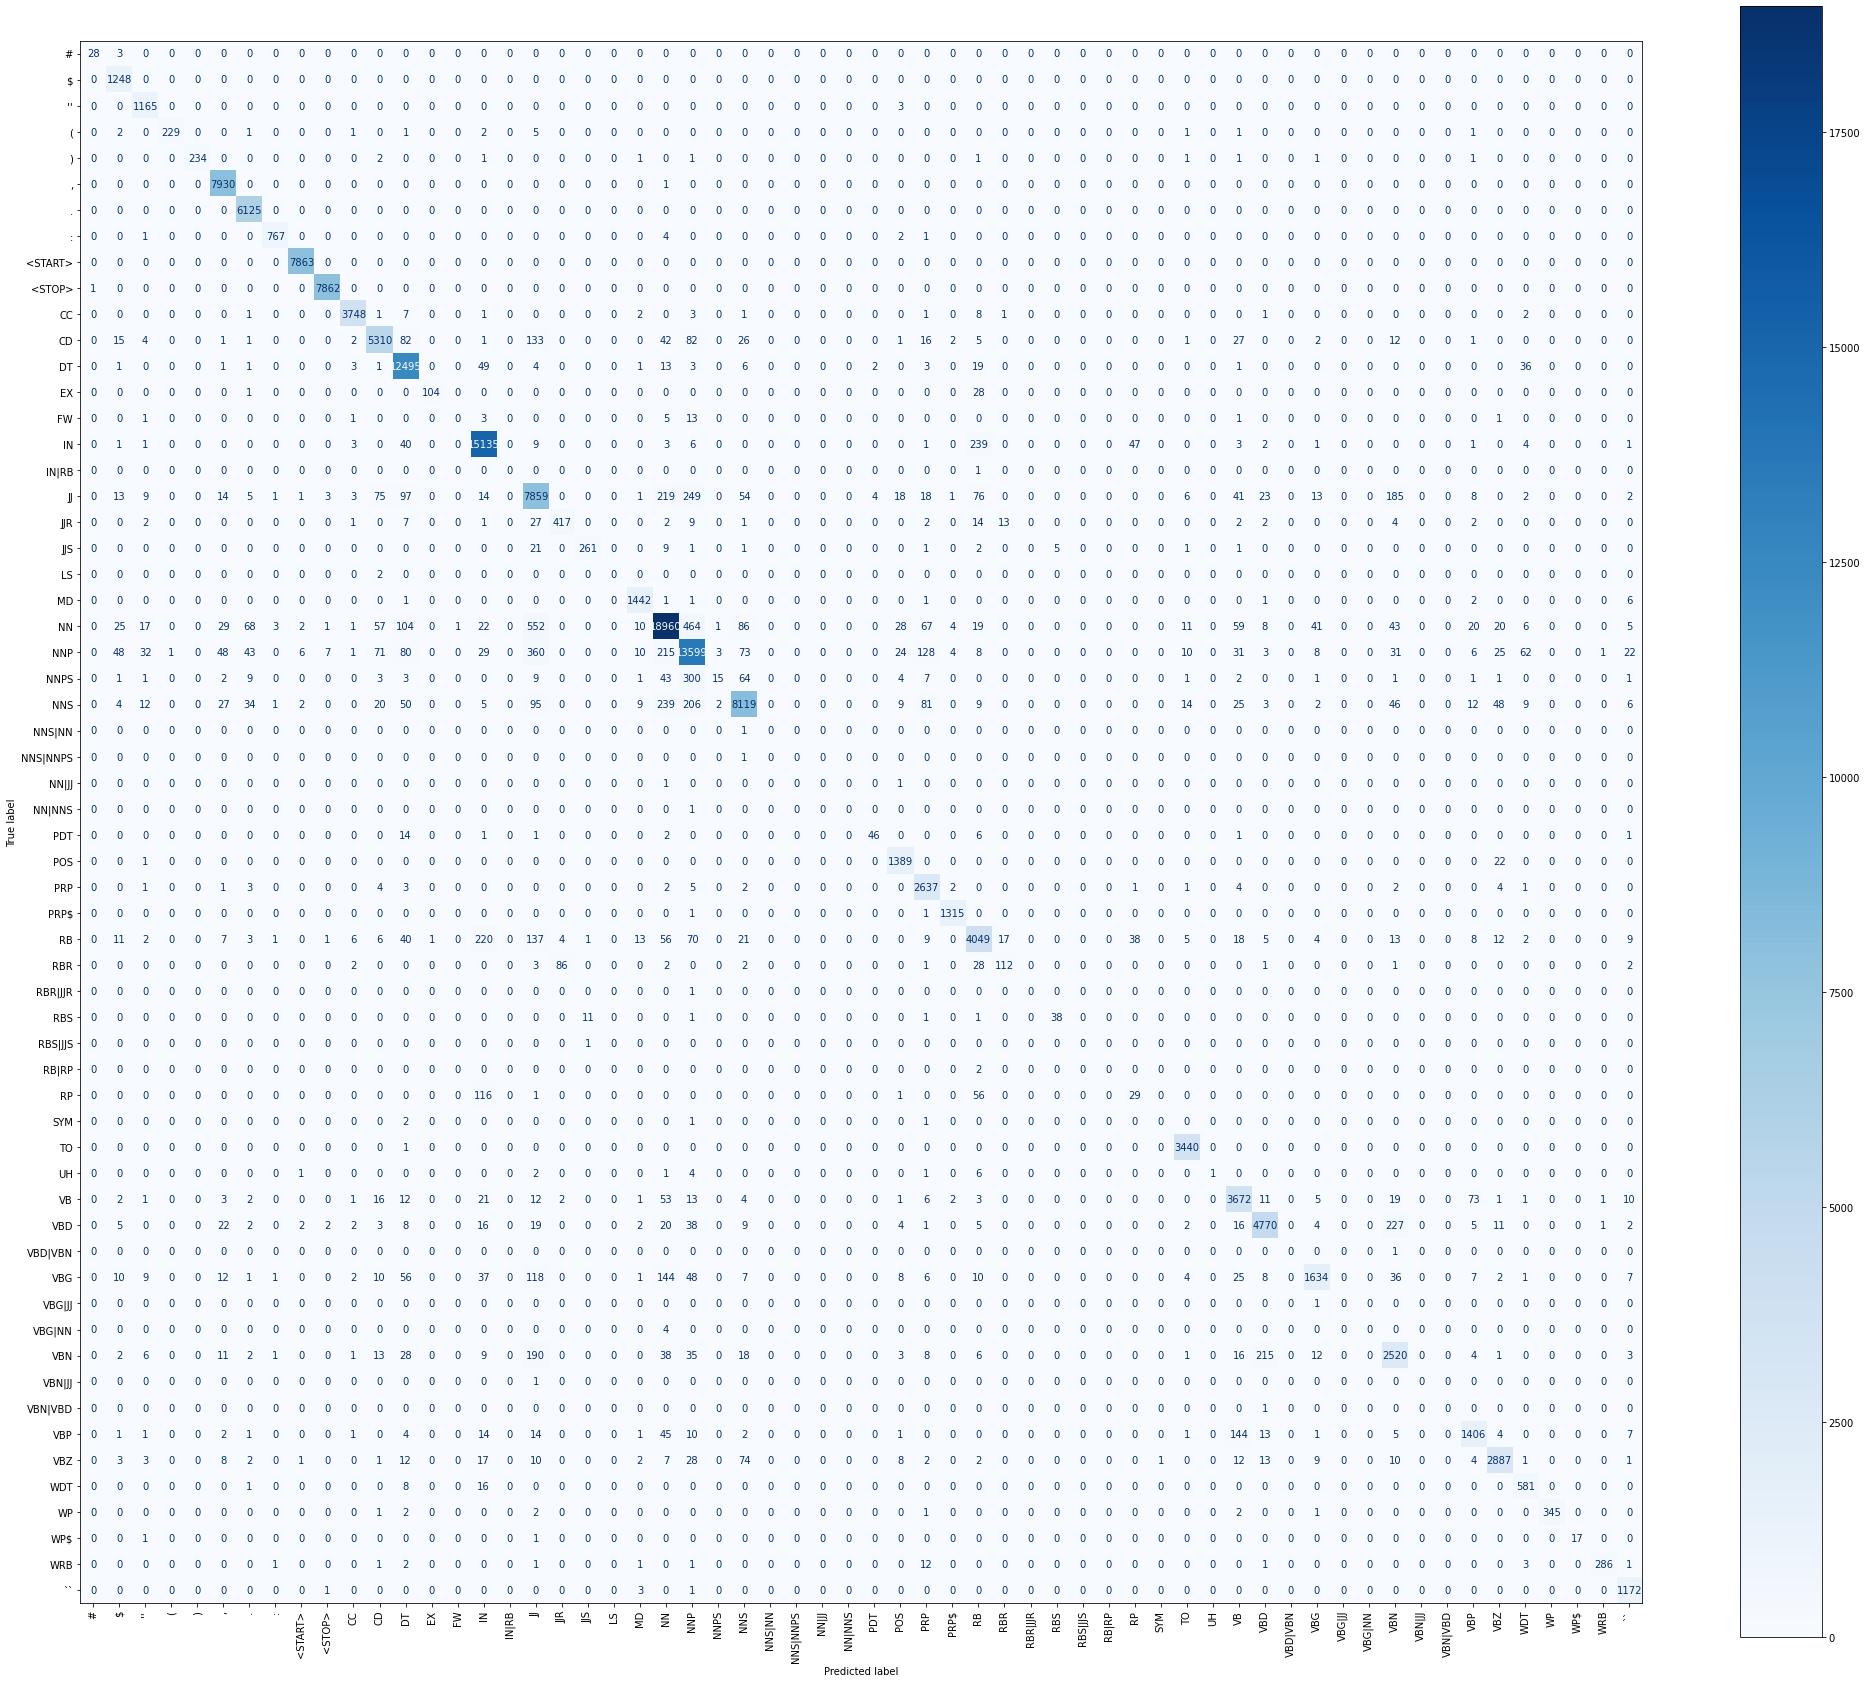

In [38]:
print("\nConfusion Matrix for dev datatset (alpha=1)")
cm_display_dev1 = metrics.ConfusionMatrixDisplay.from_predictions(dev_gold, pred_dev1, xticks_rotation='vertical', cmap='Blues')
fig_dev1 = cm_display_dev1.figure_
fig_dev1.set_figwidth(35)
fig_dev1.set_figheight(30)
#fig.suptitle('Confusion Matrix')
plt.show()

In [39]:
print("\nPredicting using alpha=1 on test dataset")
print("Total words = ", len(test_words))
pred_test1 = predictPOSSequence(test_words, states, A, B, vocab)


Predicting using alpha=1 on test dataset
Total words =  189230
Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000
Words processed:    35000
Words processed:    40000
Words processed:    45000
Words processed:    50000
Words processed:    55000
Words processed:    60000
Words processed:    65000
Words processed:    70000
Words processed:    75000
Words processed:    80000
Words processed:    85000
Words processed:    90000
Words processed:    95000
Words processed:   100000
Words processed:   105000
Words processed:   110000
Words processed:   115000
Words processed:   120000
Words processed:   125000
Words processed:   130000
Words processed:   135000
Words processed:   140000
Words processed:   145000
Words processed:   150000
Words processed:   155000
Words processed:   160000
Words processed:   165000
Words processed:   170000
Words processed:   175000
Words processed:   180000


In [40]:
accuracy_test1 = metrics.accuracy_score(test_gold, pred_test1)
print(f"Accuracy of the Viterbi algorithm is {accuracy_test1:.4f}")
print("\nClassification Report:")
print(metrics.classification_report(test_gold, pred_test1, zero_division=0))

Accuracy of the Viterbi algorithm is 0.9396

Classification Report:
              precision    recall  f1-score   support

           #       0.95      0.82      0.88        22
           $       0.89      1.00      0.94      1138
          ''       0.95      1.00      0.97      1423
           (       0.99      0.95      0.97       249
           )       1.00      0.95      0.97       252
           ,       0.99      1.00      0.99      9056
           .       0.98      1.00      0.99      7035
           :       0.99      0.99      0.99       983
     <START>       1.00      1.00      1.00      9046
      <STOP>       1.00      1.00      1.00      9046
          CC       1.00      1.00      1.00      4289
          CD       0.95      0.91      0.93      6023
          DT       0.96      0.99      0.98     14946
          EX       0.97      0.87      0.92       174
          FW       0.00      0.00      0.00        38
          IN       0.96      0.97      0.96     18147
          JJ 


Confusion Matrix for test datatset (alpha=1)


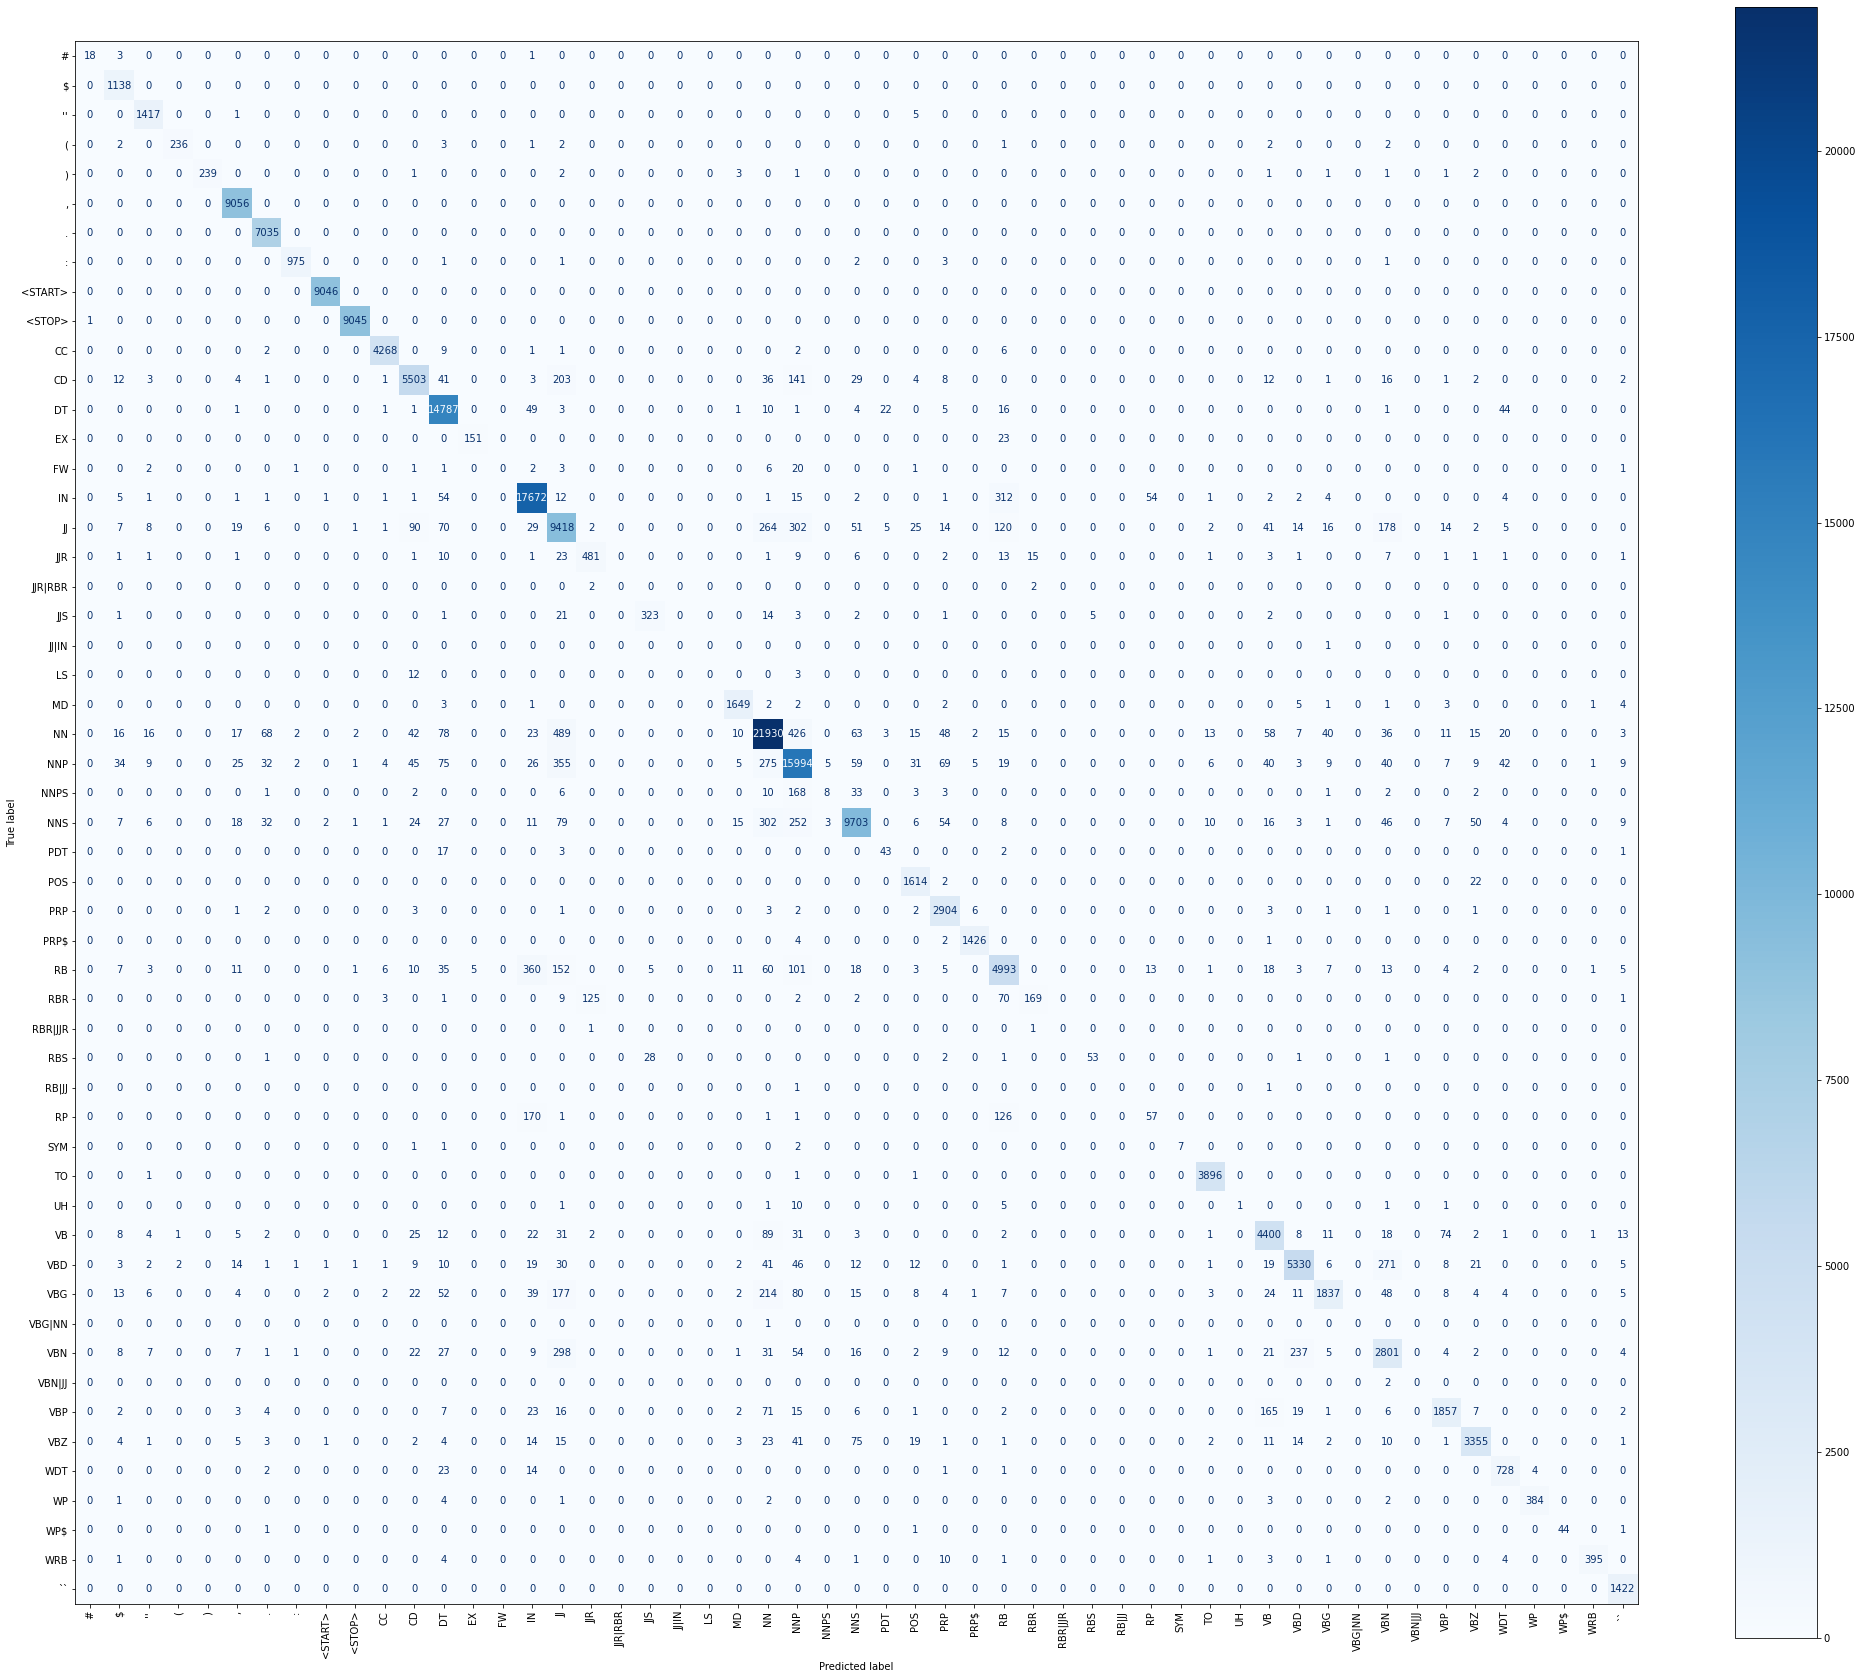

In [41]:
print("\nConfusion Matrix for test datatset (alpha=1)")
cm_display_test1 = metrics.ConfusionMatrixDisplay.from_predictions(test_gold, pred_test1, xticks_rotation='vertical', cmap='Blues')
fig_test1 = cm_display_test1.figure_
fig_test1.set_figwidth(35)
fig_test1.set_figheight(30)
#fig.suptitle('Confusion Matrix')
plt.show()

### Using Alpha = 0.001

In [42]:
# alpha = smoothing parameter.
# smoothing: By adding in the numerator and in the denominator, instead of 0, we’ll end up with a very small number.
alpha = 0.001
print("\n Now using alpha = 0.001")

# A is Transition Matrix where A(i,j) gives probability of moving from state i to state j
A = createTransitionMatrix(alpha, tag_counts, transition_counts)

# create emission probability matrix. 
# The matrix B is of dimension (num_tags, N), 
#          where num_tags is the number of possible parts-of-speech tags. and N is size of vocabulary
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))


 Now using alpha = 0.001


In [43]:
print("\nPredicting using alpha=0.001 on dev dataset")
print("Total words = ", len(dev_words))
pred_dev2 = predictPOSSequence(dev_words, states, A, B, vocab)


Predicting using alpha=0.001 on dev dataset
Total words =  163883
Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000
Words processed:    35000
Words processed:    40000
Words processed:    45000
Words processed:    50000
Words processed:    55000
Words processed:    60000
Words processed:    65000
Words processed:    70000
Words processed:    75000
Words processed:    80000
Words processed:    85000
Words processed:    90000
Words processed:    95000
Words processed:   100000
Words processed:   105000
Words processed:   110000
Words processed:   115000
Words processed:   120000
Words processed:   125000
Words processed:   130000
Words processed:   135000
Words processed:   140000
Words processed:   145000
Words processed:   150000
Words processed:   155000
Words processed:   160000


In [44]:
accuracy_dev2 = metrics.accuracy_score(dev_gold, pred_dev2)
print(f"Accuracy of the Viterbi algorithm is {accuracy_dev2:.4f}")
print("\nClassification Report:")
print(metrics.classification_report(dev_gold, pred_dev2, zero_division=0))

Accuracy of the Viterbi algorithm is 0.9514

Classification Report:
              precision    recall  f1-score   support

           #       0.91      1.00      0.95        31
           $       0.99      1.00      1.00      1248
          ''       0.97      1.00      0.99      1168
           (       0.87      1.00      0.93       244
           )       0.90      1.00      0.95       244
           ,       1.00      1.00      1.00      7931
           .       1.00      1.00      1.00      6125
           :       0.99      0.99      0.99       775
     <START>       1.00      1.00      1.00      7863
      <STOP>       1.00      1.00      1.00      7863
          CC       0.99      0.99      0.99      3777
          CD       0.97      0.96      0.96      5766
          DT       0.99      0.99      0.99     12639
          EX       0.84      0.98      0.91       133
          FW       0.09      0.48      0.15        25
          IN       0.98      0.97      0.98     15497
       IN|JJ 


Confusion Matrix for dev datatset (alpha=0.001)


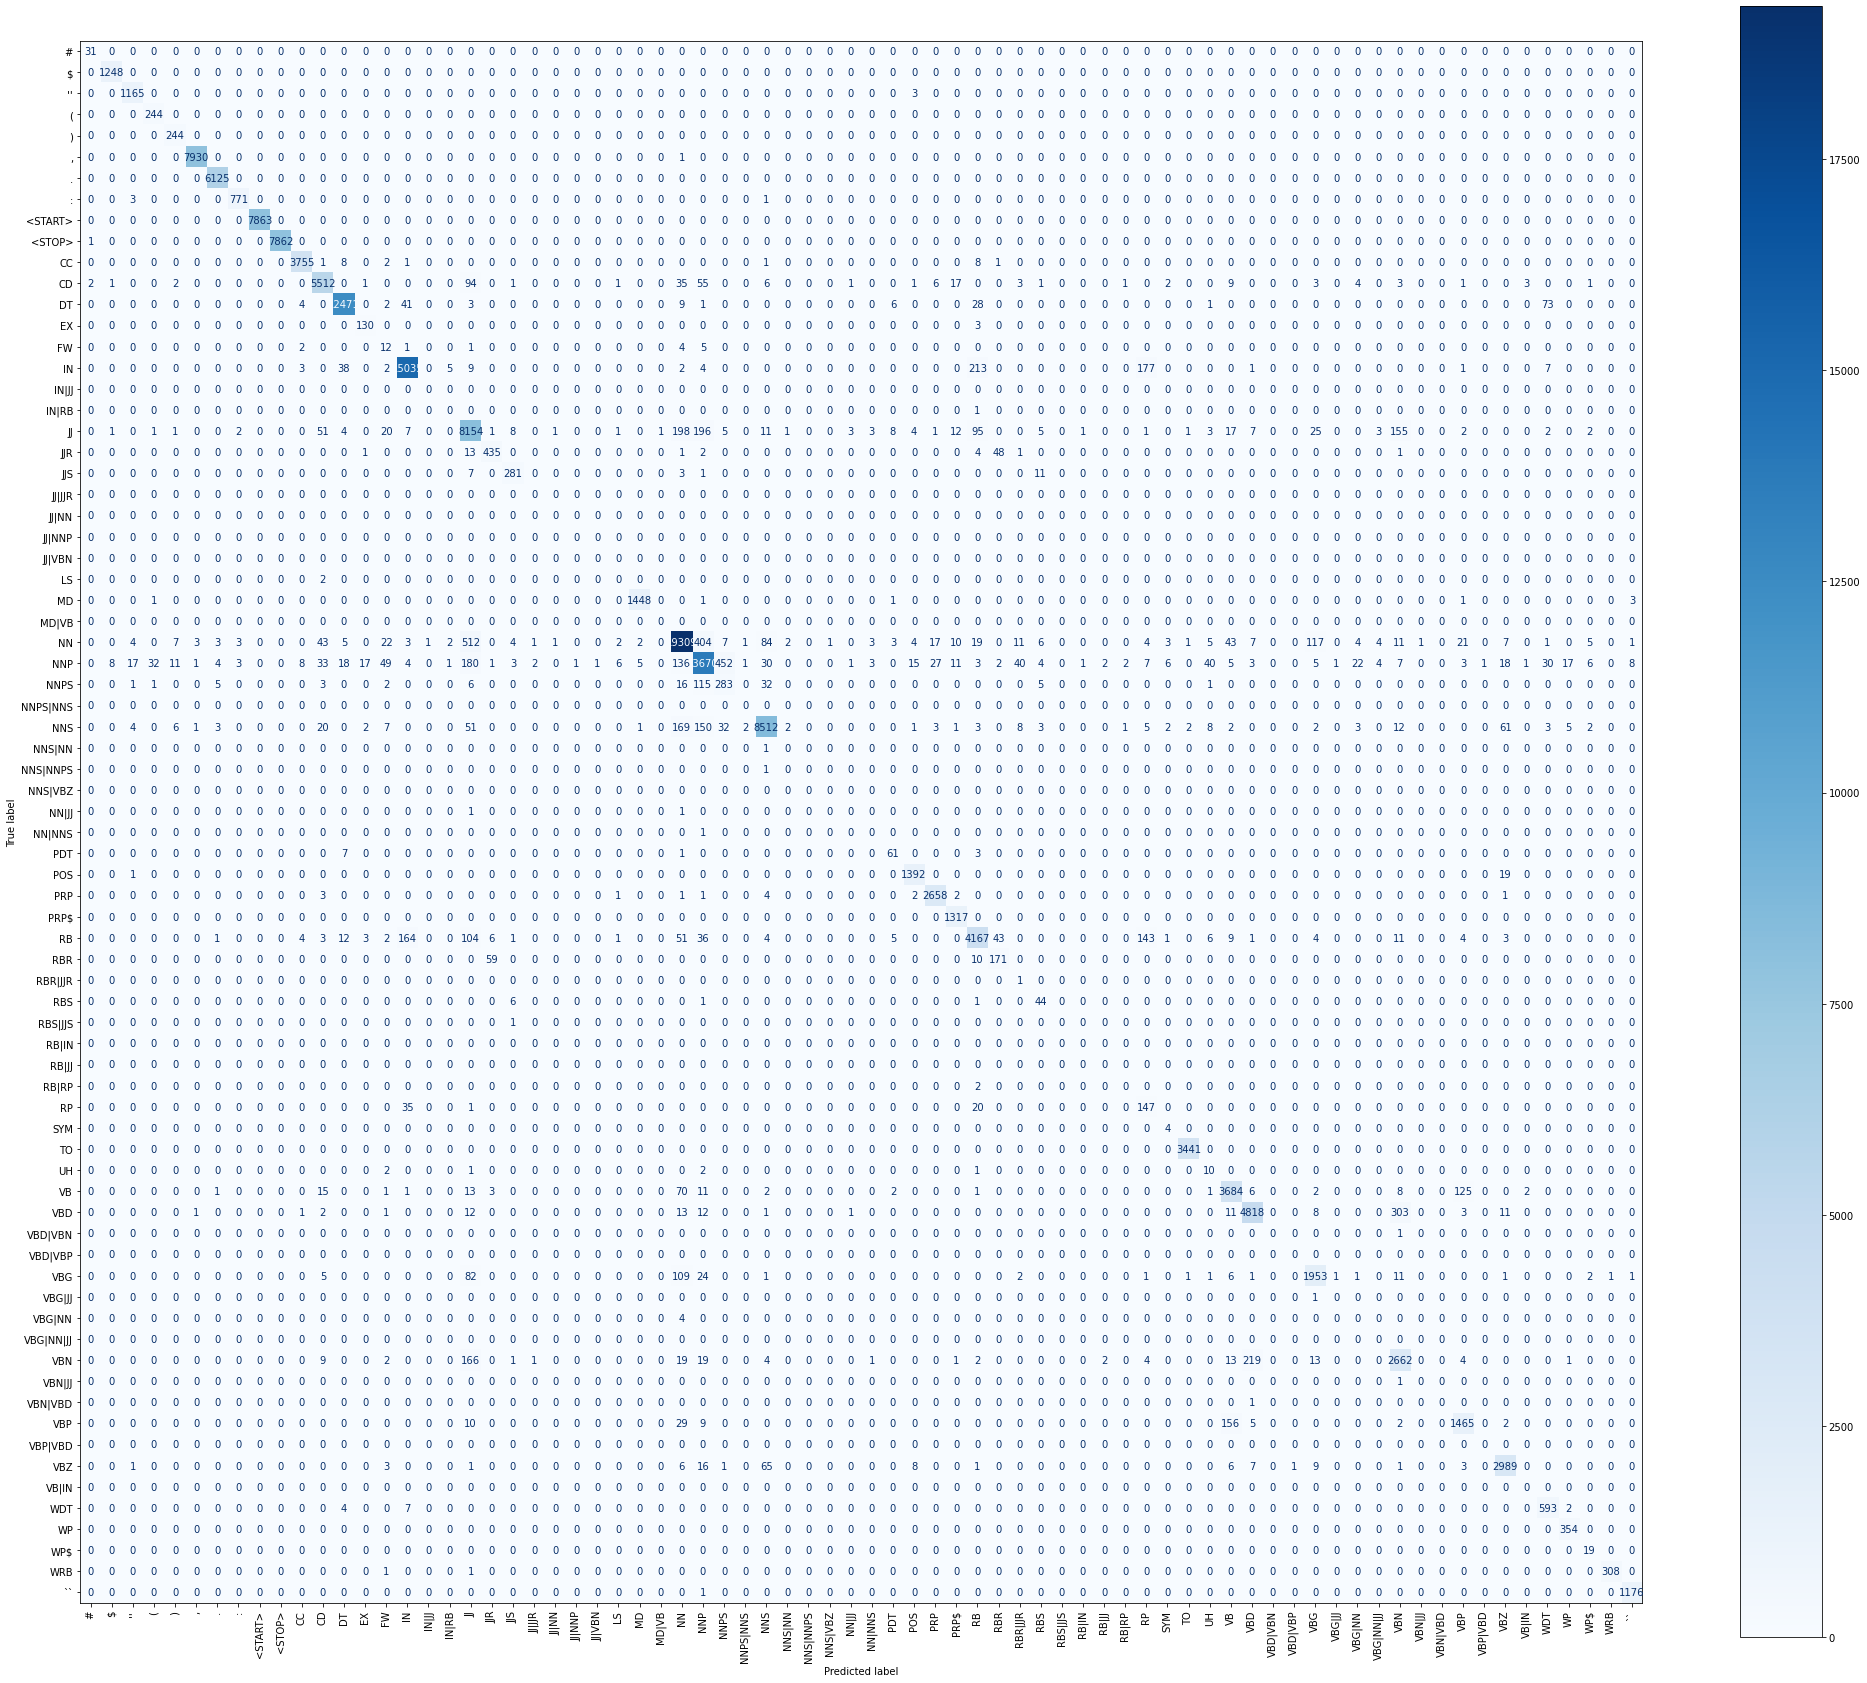

In [45]:
print("\nConfusion Matrix for dev datatset (alpha=0.001)")
cm_display_dev2 = metrics.ConfusionMatrixDisplay.from_predictions(dev_gold, pred_dev2, xticks_rotation='vertical', cmap='Blues')
fig_dev2 = cm_display_dev2.figure_
fig_dev2.set_figwidth(35)
fig_dev2.set_figheight(30)
#fig.suptitle('Confusion Matrix')
plt.show()

In [46]:
print("\nPredicting using alpha=0.001 on test dataset")
print("Total words = ", len(test_words))
pred_test2 = predictPOSSequence(test_words, states, A, B, vocab)


Predicting using alpha=0.001 on test dataset
Total words =  189230
Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000
Words processed:    35000
Words processed:    40000
Words processed:    45000
Words processed:    50000
Words processed:    55000
Words processed:    60000
Words processed:    65000
Words processed:    70000
Words processed:    75000
Words processed:    80000
Words processed:    85000
Words processed:    90000
Words processed:    95000
Words processed:   100000
Words processed:   105000
Words processed:   110000
Words processed:   115000
Words processed:   120000
Words processed:   125000
Words processed:   130000
Words processed:   135000
Words processed:   140000
Words processed:   145000
Words processed:   150000
Words processed:   155000
Words processed:   160000
Words processed:   165000
Words processed:   170000
Words processed:   175000
Words processed:   180

In [47]:
accuracy_test2 = metrics.accuracy_score(test_gold, pred_test2)
print(f"Accuracy of the Viterbi algorithm is {accuracy_test2:.4f}")
print("\nClassification Report:")
print(metrics.classification_report(test_gold, pred_test2, zero_division=0))

Accuracy of the Viterbi algorithm is 0.9549

Classification Report:
              precision    recall  f1-score   support

           #       0.96      1.00      0.98        22
           $       1.00      1.00      1.00      1138
          ''       1.00      1.00      1.00      1423
           (       0.99      1.00      0.99       249
           )       0.99      1.00      1.00       252
           ,       1.00      1.00      1.00      9056
           .       1.00      1.00      1.00      7035
           :       1.00      1.00      1.00       983
     <START>       1.00      1.00      1.00      9046
      <STOP>       1.00      1.00      1.00      9046
          CC       1.00      1.00      1.00      4289
          CD       0.96      0.94      0.95      6023
          DT       0.99      0.99      0.99     14946
          EX       0.96      0.99      0.97       174
          FW       0.16      0.42      0.24        38
          IN       0.98      0.97      0.97     18147
       IN|RB 


Confusion Matrix for test datatset (alpha=0.001)


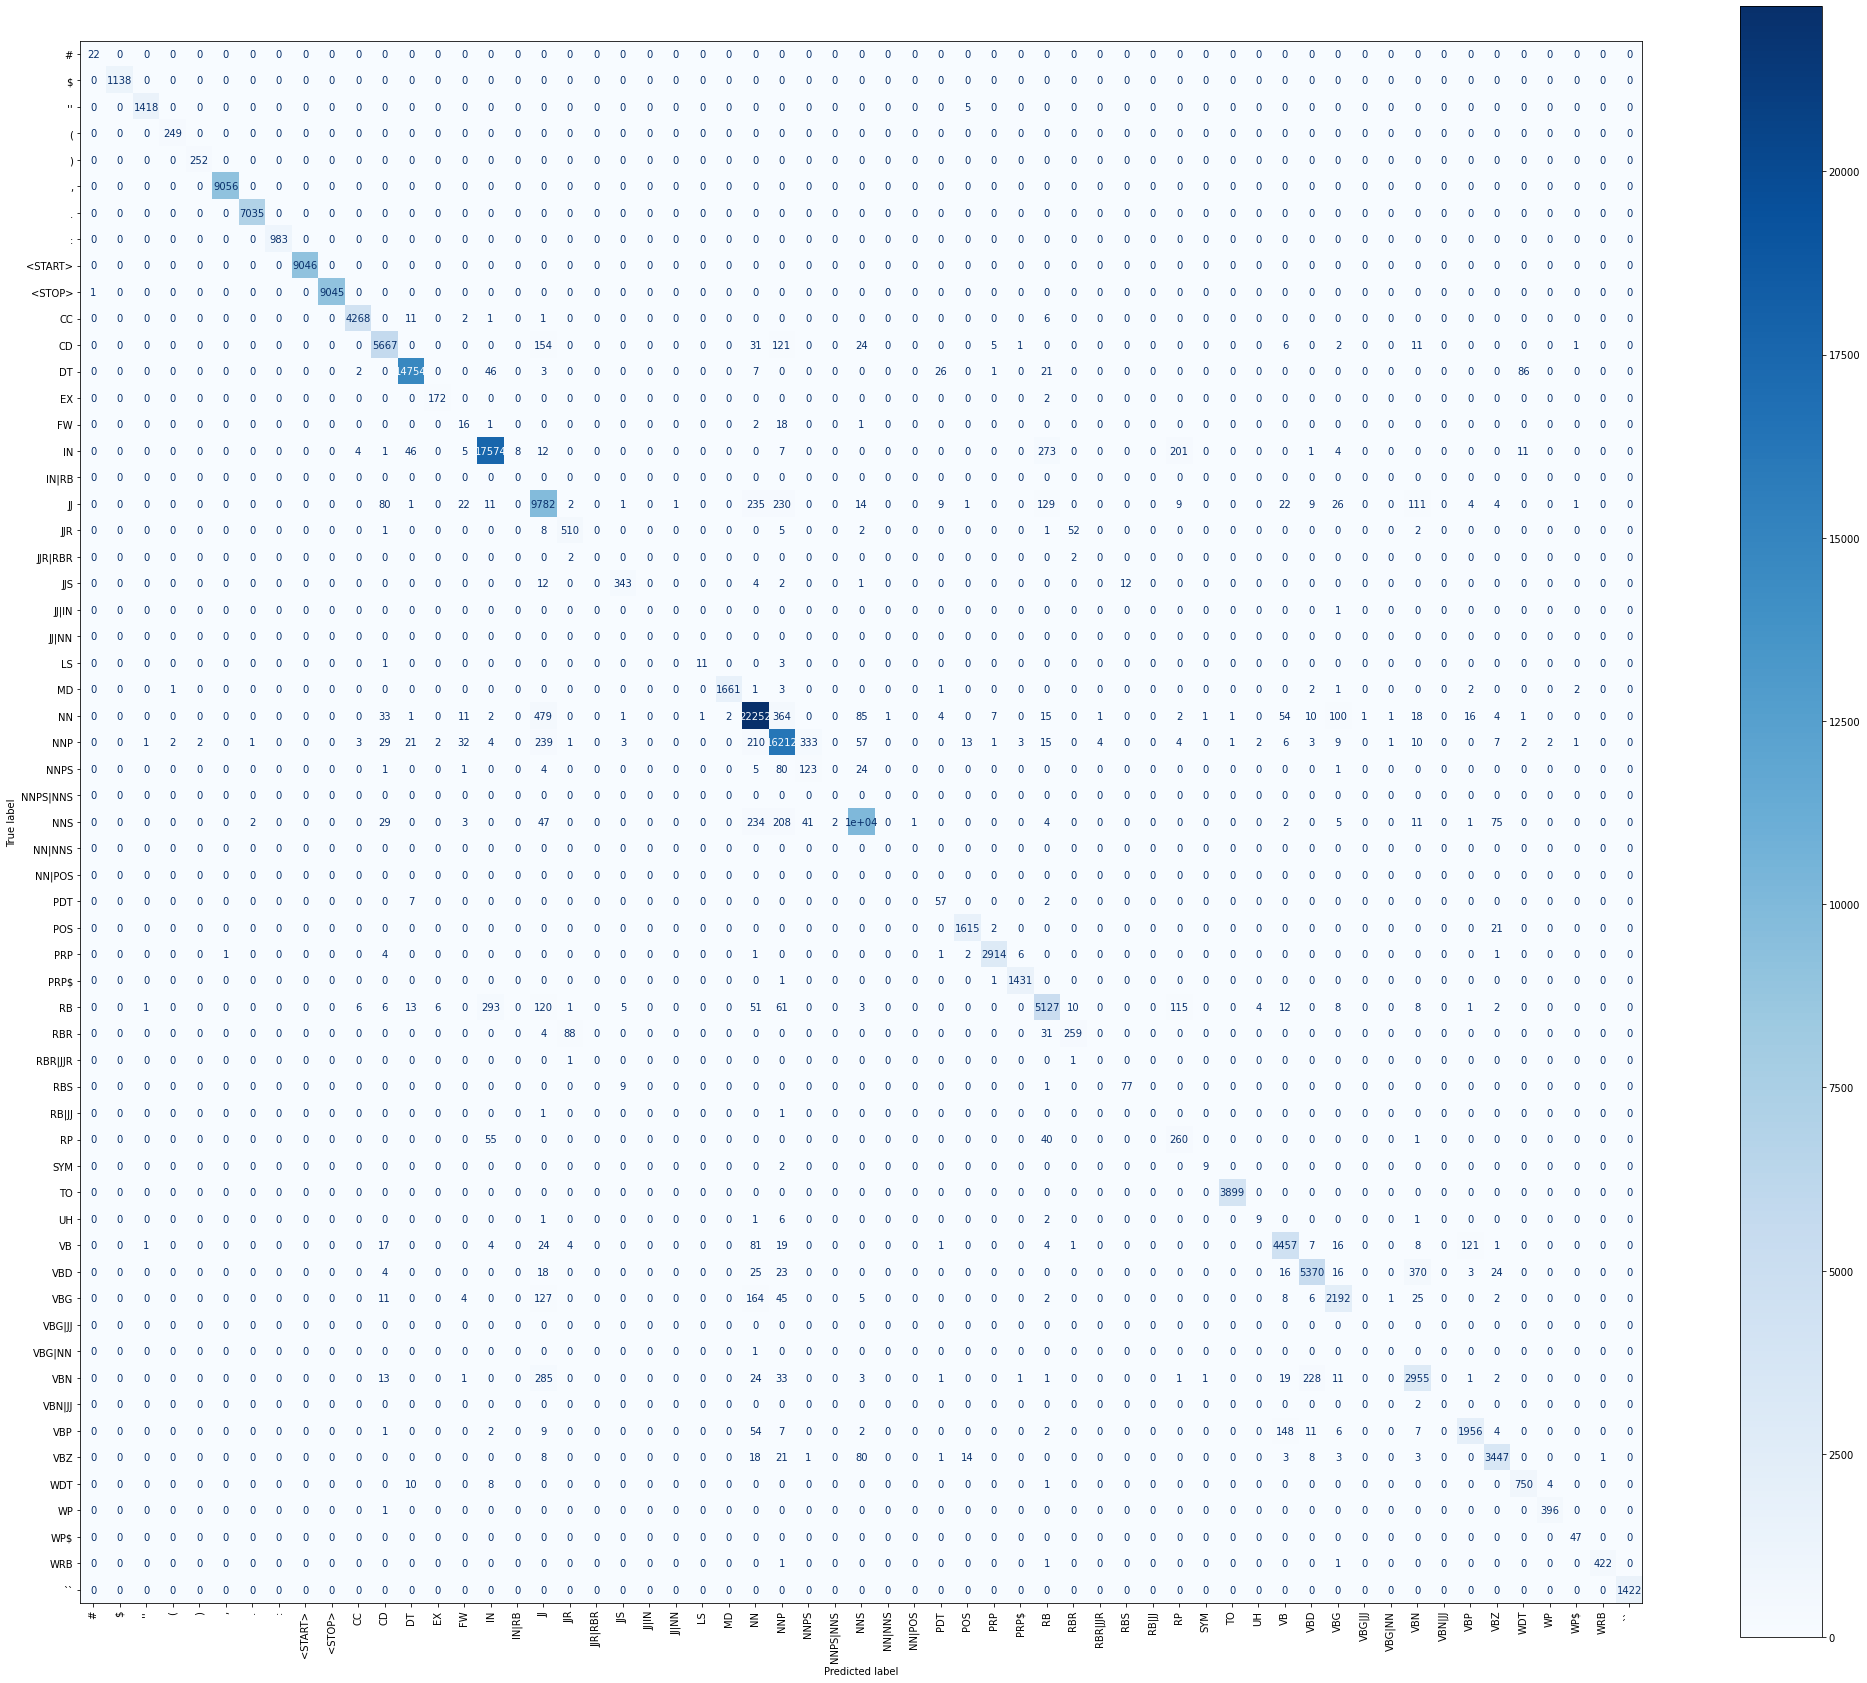

In [48]:
print("\nConfusion Matrix for test datatset (alpha=0.001)")
cm_display_test2 = metrics.ConfusionMatrixDisplay.from_predictions(test_gold, pred_test2, xticks_rotation='vertical', cmap='Blues')
fig_test2 = cm_display_test2.figure_
fig_test2.set_figwidth(35)
fig_test2.set_figheight(30)
#fig.suptitle('Confusion Matrix')
plt.show()

In [49]:
#display(pd.crosstab(dev_gold, pred))


Subset of Confusion Matrix for test datatset (alpha=0.001)


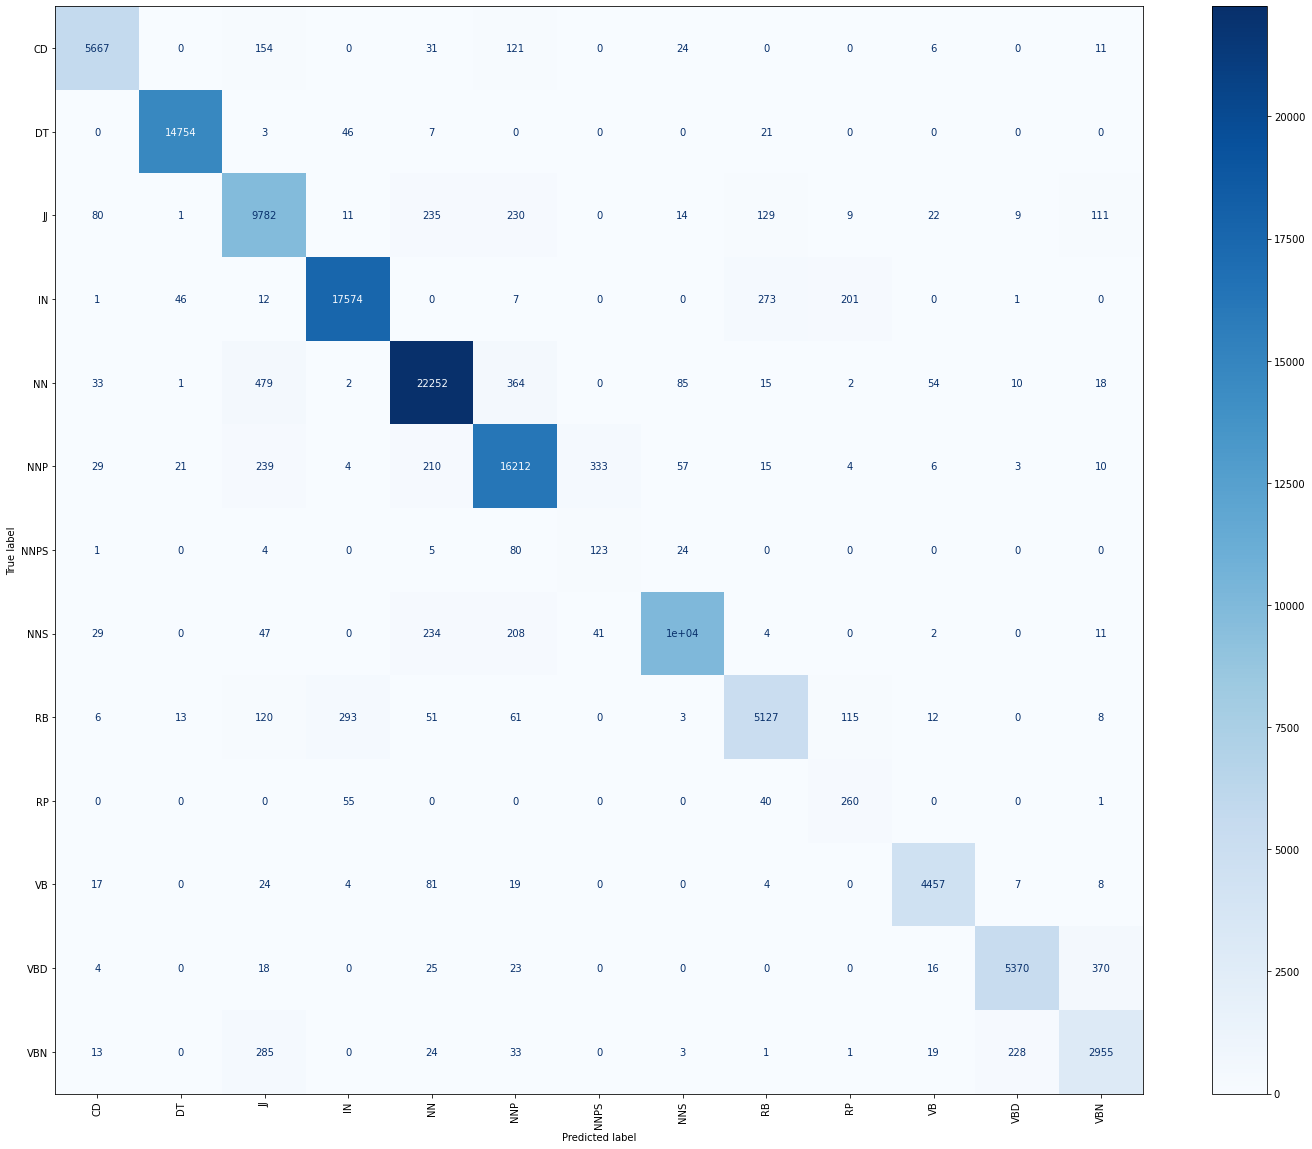

In [50]:
print("\nSubset of Confusion Matrix for test datatset (alpha=0.001)")
labels = ['CD','DT','JJ','IN','NN','NNP','NNPS','NNS','RB','RP','VB','VBD','VBN']
sub_cm_display_dev1 = metrics.ConfusionMatrixDisplay.from_predictions(test_gold, pred_test2, labels=labels, xticks_rotation='vertical', cmap = 'Blues')
sub_fig_dev1 = sub_cm_display_dev1.figure_
sub_fig_dev1.set_figwidth(25)
sub_fig_dev1.set_figheight(20)
plt.show()

In [51]:
# relatively many tags with (NN, NNP) are wrongly predicted as (CD, JJ, RB, VB).
df_test2 = pd.DataFrame({'word': test_words, 'POS': test_gold, 'Pred POS': pred_test2 })
diff_df = df_test2[df_test2.apply(lambda x: x['POS'] != x['Pred POS'], axis = 1)]
group = diff_df.groupby('POS')
print("\n Number of words with wrong predictions")
print("relatively many tags with (NN, NNP) are wrongly predicted as (CD, JJ, RB, VB)")
print(group.size().reset_index(name='# samples'))


 Number of words with wrong predictions
relatively many tags with (NN, NNP) are wrongly predicted as (CD, JJ, RB, VB)
        POS  # samples
0        ''          5
1    <STOP>          1
2        CC         21
3        CD        356
4        DT        192
5        EX          2
6        FW         22
7        IN        573
8        JJ        922
9       JJR         71
10  JJR|RBR          4
11      JJS         31
12    JJ|IN          1
13       LS          4
14       MD         13
15       NN       1216
16      NNP       1024
17     NNPS        116
18      NNS        665
19      PDT          9
20      POS         23
21      PRP         16
22     PRP$          2
23       RB        726
24      RBR        123
25  RBR|JJR          2
26      RBS         10
27    RB|JJ          2
28       RP         96
29      SYM          2
30       UH         11
31       VB        309
32      VBD        499
33      VBG        400
34   VBG|NN          1
35      VBN        625
36   VBN|JJ          2
37     

In [52]:
NN_df = diff_df.loc[(diff_df['POS'] == 'NN') & (diff_df['word'] != '<unk>')]
print("\nNumber of wrong predicted POS for NN:")
print(NN_df['Pred POS'].value_counts())


Number of wrong predicted POS for NN:
Pred POS
JJ         339
NNP        182
VBG         98
VB          51
NNS         23
VBP         16
RB          11
VBD          9
PRP          7
CD           4
VBN          4
PDT          4
RP           2
IN           2
MD           2
VBG|NN       1
VBG|JJ       1
LS           1
DT           1
NN|NNS       1
JJS          1
TO           1
RBR|JJR      1
WDT          1
SYM          1
Name: count, dtype: int64


In [53]:
print("\n examples of NN identified as VB")
x2 = NN_df.loc[(diff_df['Pred POS'] == 'VB')]
print(x2['word'].unique())


 examples of NN identified as VB
['blast' 'press' 'play' 'pay' 'mind' 'appeal' 'service' 'sell' 'bite'
 'shop' 'question' 'extract' 'trade' 'raise' 'affect' 'concentrate'
 'purchase' 'whack' 'spark' 'profit' 'deal' 'turn' 'talk' 'matter' 'scorn'
 'sway' 'cause' 'answer' 'speed' 'dispatch' 'buy' 'lead' 'produce' 'phase'
 'ease' 'halt' 'panic' 'heed' 'block' 'Pay' 'help' 'head']


In [54]:
# example of ambiguities in emission_counts
print("\n Examples of ambiguities: ")
for tup,cnt in emission_counts.items():
    if tup[1] in ['affect', 'lead', 'sell']: print (tup, cnt) 


 Examples of ambiguities: 
('NN', 'lead') 38
('VB', 'sell') 404
('VB', 'affect') 47
('JJ', 'lead') 17
('VBP', 'sell') 43
('VB', 'lead') 67
('VBN', 'lead') 1
('NN', 'sell') 21
('VBP', 'lead') 11
('VBP', 'affect') 5
('JJ', 'sell') 10


In [55]:
#x3 = diff_df.groupby(['POS','Pred POS']).agg({'word':'count'}).reset_index()
#x4 = x3.loc[(x3['POS'] == 'NN')]
#x4

In [56]:
results = [
            ['Baseline', accuracy_baseline_dev, accuracy_baseline_test], 
            ['HMM (alpha=1)', accuracy_dev1, accuracy_test1],
            ['HMM (alpha=0.001)', accuracy_dev2, accuracy_test2]
          ]
   
results_df = pd.DataFrame(results, columns =['Method', 'Accuracy for dev', 'Accuracy for test'])
results_df['Accuracy for dev'] = results_df['Accuracy for dev'].mul(100).round(2).astype(str).add(' %')
results_df['Accuracy for test'] = results_df['Accuracy for test'].mul(100).round(2).astype(str).add(' %')

display(results_df)

,Method,Accuracy for dev,Accuracy for test
0,Baseline,92.28 %,92.47 %
1,HMM (alpha=1),93.52 %,93.96 %
2,HMM (alpha=0.001),95.14 %,95.49 %
